### Paketimporte

In [1]:
import pandas as pd
import numpy as np

### Vorbereitung der Daten

Preise

In [2]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

Downtime

In [3]:
df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

Kundendaten

In [4]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

Vereinen der Transaktionsdaten

In [5]:
def read_regio_data(region, kind):
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

In [6]:
# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

### Gewinn sinkt, weil Kosten steigen? → auf Regionen und Markplatz beziehen

<Axes: xlabel='year', ylabel='profit'>

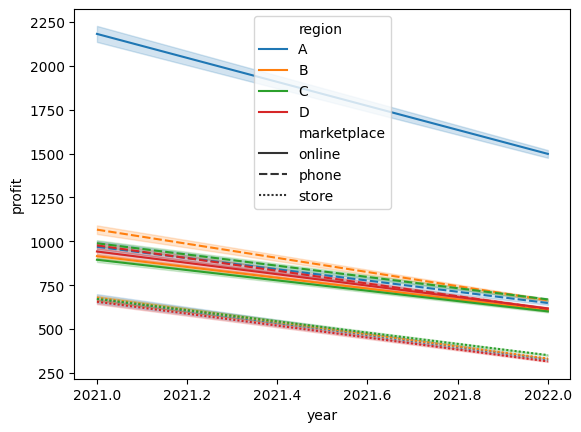

In [7]:
import seaborn as sns

sns.lineplot(data=df_reg_main, x="year", y="profit", hue="region", style="marketplace")

<Axes: xlabel='year', ylabel='profit_per_unit'>

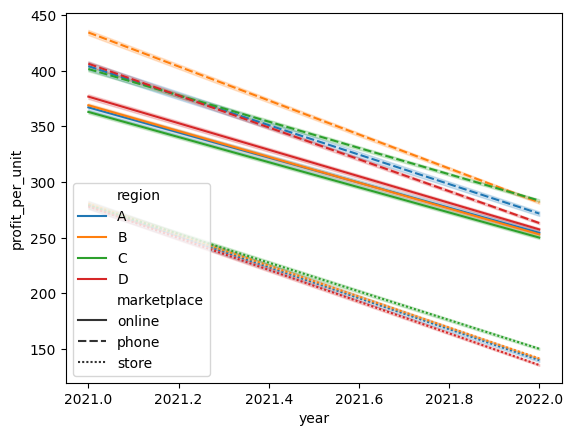

In [8]:
sns.lineplot(data=df_reg_main, x="year", y="profit_per_unit", hue="region", style="marketplace")

<Axes: xlabel='year', ylabel='cost_per_unit'>

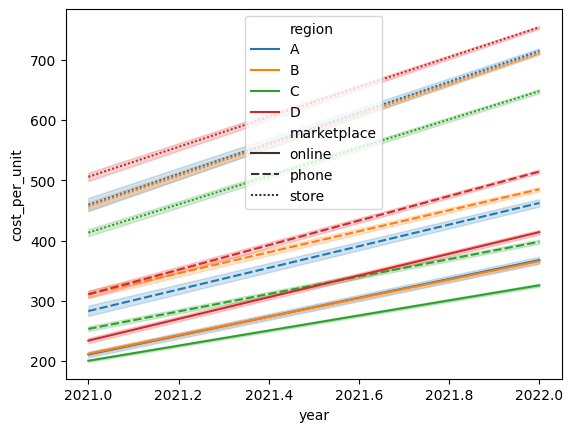

In [9]:
sns.lineplot(data=df_reg_main, x="year", y="cost_per_unit", hue="region", style="marketplace")

<Axes: xlabel='year', ylabel='price'>

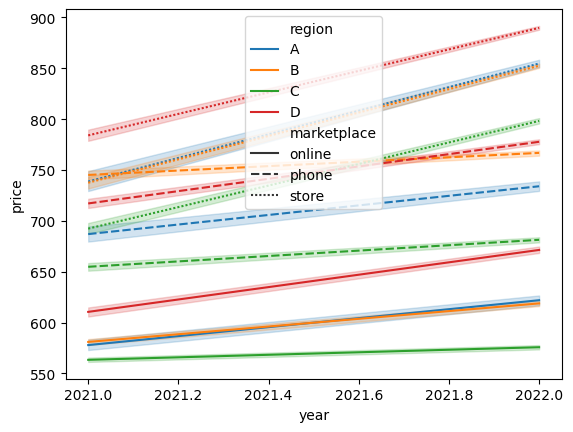

In [10]:
sns.lineplot(data=df_reg_main, x="year", y="price", hue="region", style="marketplace")

#### Sind Stores ineffektiv? (auf Umsatz, menge, Gewinn etc. beziehen)

<Axes: xlabel='marketplace', ylabel='amount'>

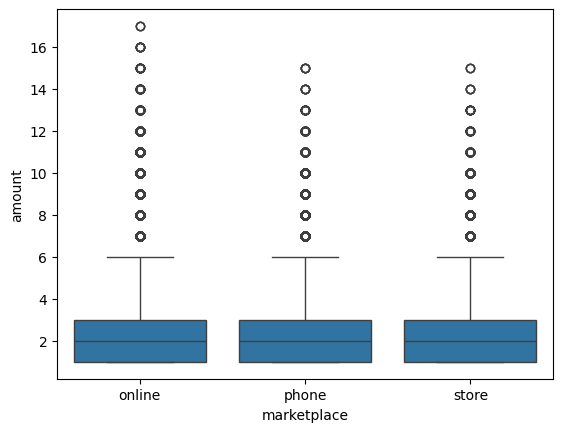

In [19]:
sns.boxplot(data=df_reg_main, x="marketplace", y="amount")

In [20]:
df_reg_main.groupby(['marketplace'])['amount'].mean()

marketplace
online    2.822527
phone     2.309044
store     2.227111
Name: amount, dtype: float64

<Axes: xlabel='marketplace', ylabel='cost_per_unit'>

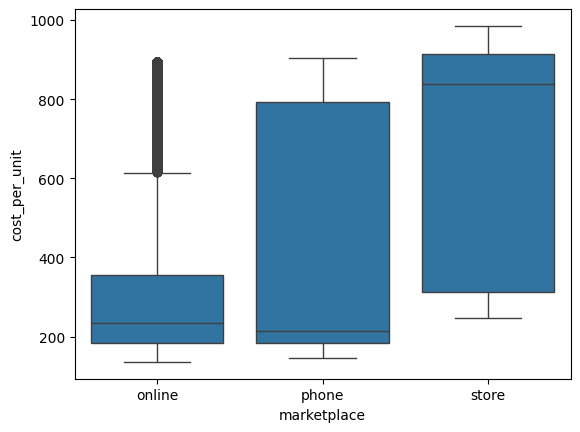

In [22]:
sns.boxplot(data=df_reg_main, x="marketplace", y="cost_per_unit")

<Axes: xlabel='marketplace', ylabel='price'>

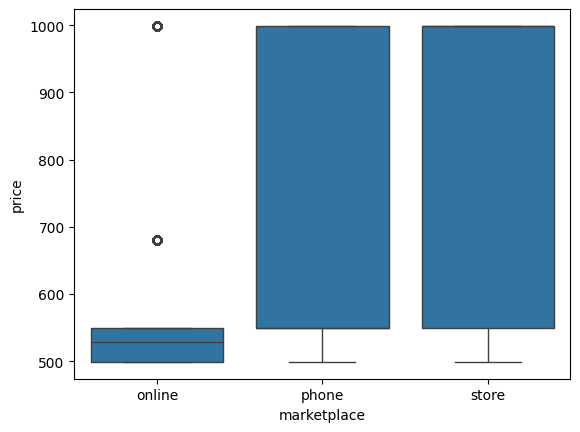

In [24]:
sns.boxplot(data=df_reg_main, x="marketplace", y="price")

In [33]:
# Group by marketplace and count the number of transactions with a discount less than 1
df_reg_main.groupby(['marketplace'])['discount'].apply(lambda x: (x < 1).sum())

marketplace
online    16634
phone      8764
store      8006
Name: discount, dtype: int64

<Axes: xlabel='marketplace', ylabel='revenue'>

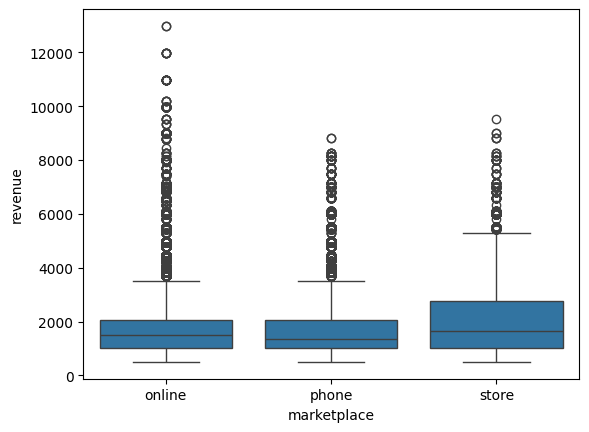

In [25]:
sns.boxplot(data=df_reg_main, x="marketplace", y="revenue")

<Axes: xlabel='marketplace', ylabel='profit'>

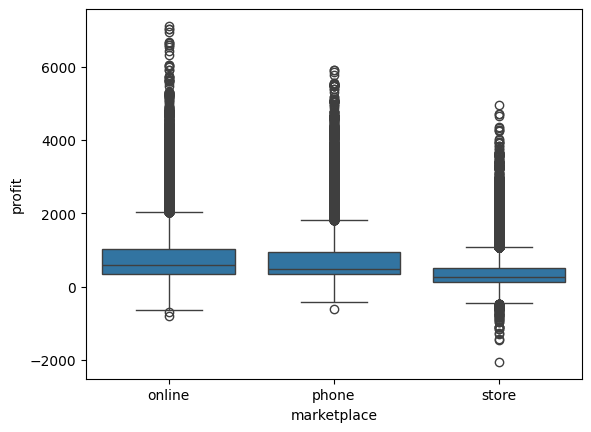

In [26]:
sns.boxplot(data=df_reg_main, x="marketplace", y="profit")